In [49]:
from langgraph.graph import StateGraph,START,END
from langchain_openai import  ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict,Literal,Annotated
from langchain_core.messages import SystemMessage,HumanMessage
from pydantic import BaseModel,Field
import operator

In [50]:
load_dotenv()

True

In [51]:
generator_llm = ChatOpenAI(model='gpt-4o-mini',
                  
    base_url="https://openrouter.ai/api/v1"
                   
                   )
evaluation_llm = ChatOpenAI(model='gpt-4o-mini',
              
    base_url="https://openrouter.ai/api/v1"
                   
                   )
optimizer_llm = ChatOpenAI(model='gpt-4o-mini',
                  
    base_url="https://openrouter.ai/api/v1"
                   
                   )

In [52]:
class str_output(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [53]:
structured_evaluator_llm = evaluation_llm.with_structured_output(str_output)

In [54]:
class tweetState(TypedDict):

    topic:str
    tweet:str
    evaluation:Literal["approved","needs_imporvement"]
    feedback:str
    iteration:int
    max_iteration:int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]


In [55]:
def generate_tweet(state : tweetState):

     messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
     response = generator_llm.invoke(messages).content

    # return response
     return {'tweet': response, 'tweet_history': [response]}

In [56]:
def evaluate_tweet(state: tweetState):

  

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality - Is this fresh, or have you seen it a hundred times before?  
2. Humor - Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness - Is it short, sharp, and scroll-stopping?  
4. Virality Potential - Would people retweet or share it?  
5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [57]:
def optimize_tweet(state: tweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [58]:
def route_evaluation(state: tweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

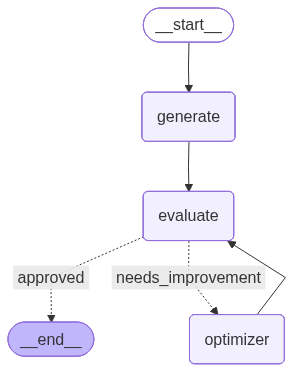

In [59]:
graph=StateGraph(tweetState)

graph.add_node("generate",generate_tweet)
graph.add_node("evaluate",evaluate_tweet)
graph.add_node("optimizer",optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimizer'})
graph.add_edge('optimizer', 'evaluate')

workflow = graph.compile()

workflow

In [60]:
initial_state = {
    "topic": "PAKISTAN JUST BOMBED ITS OWN VILLAGE",
    "iteration": 1,
    "max_iteration": 2
}
result = workflow.invoke(initial_state)

In [61]:
result

{'topic': 'PAKISTAN JUST BOMBED ITS OWN VILLAGE',
 'tweet': '"Pakistan just bombed its own village—talk about the ultimate \'neighborhood revitalization\' plan! Who needs a real estate agent when you can literally eliminate the competition? #UrbanDevelopment #RealEstateGoals"',
 'evaluation': 'needs_improvement',
 'feedback': "The tweet attempts a bold and dark humor angle by juxtaposing violent imagery with real estate terms, but it comes across as overly insensitive given the serious nature of the subject matter. Originality suffers due to the tired trope of using extreme violence as a metaphor, which dilutes its impact. While it’s somewhat punchy, the humor isn't effective enough to elicit genuine amusement and risks provoking backlash rather than shares, impacting its virality potential. Additionally, the format is appropriate but lacks the finesse needed for a successful tweet.",
 'iteration': 2,
 'max_iteration': 2,
 'tweet_history': ['Pakistan just bombed its own village. That’s